<a href="https://colab.research.google.com/github/jamo254/text_processing_model/blob/main/generative_text_rnn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#<center>Introduction to text generation Using RNN </center>



### Setup
### Importing required libraries

In [ ]:
import tensorflow as tf
import numpy as np
import os
import time

In [ ]:
# Uploading data
text_file = tf.keras.utils.get_file('shakespeare.txt', 'https://storage.googleapis.com/download.tensorflow.org/data/shakespeare.txt')

1115394/1115394 [==============================] - 0s 0us/step


In [ ]:
# Reading the file content
text = open(text_file, 'rb').read().decode(encoding='utf-8') 
print(f'Length of text: {len(text)} characters')

Length of text: 1115394 characters


In [ ]:
print(text[:260])

First Citizen:
Before we proceed any further, hear me speak.

All:
Speak, speak.

First Citizen:
You are all resolved rather to die than to famish?

All:
Resolved. resolved.

First Citizen:
First, you know Caius Marcius is chief enemy to the people.

All:
We k


In [ ]:
# Finding unique characters in a the file
vocab = sorted(set(text))
print(f'{len(vocab)} unique characters')
print(vocab)

65 unique characters
['\n', ' ', '!', '$', '&', "'", ',', '-', '.', '3', ':', ';', '?', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']


## Vectorization and Tokenization 

###Vectorize the text
- Before training you need to  represent the strings numerically.
- The tf.keras.layers.StringLookup layer can convert each character into a numeric ID. It just needs the text to be split into tokens first.


```
# Example of tokenization
example_texts = ['abcdefg', 'xyz']

chars = tf.strings.unicode_split(example_texts, input_encoding='UTF-8')
chars
```




In [ ]:
sample_texts = ['abcdefg', 'xyz']
char_tokens = tf.strings.unicode_split(sample_texts, input_encoding="UTF-8")
char_tokens

<tf.RaggedTensor [[b'a', b'b', b'c', b'd', b'e', b'f', b'g'], [b'x', b'y', b'z']]>

### Creating a layer using 

In [ ]:
ids_from_char_tokens = tf.keras.layers.StringLookup(
    vocabulary=list(vocab), mask_token=None
)

In [ ]:
# Converting tokens to character IDs 
ids = ids_from_char_tokens(char_tokens)
ids

<tf.RaggedTensor [[40, 41, 42, 43, 44, 45, 46], [63, 64, 65]]>

### Inverting the representation above in order to recover human readable strings


In [ ]:
chars_from_ids = tf.keras.layers.StringLookup(
    vocabulary=ids_from_char_tokens.get_vocabulary(), invert=True, mask_token=None
)

In [ ]:
# This layer recovers the characters from the vectors of IDs, and returns them as a tf.RaggedTensor of characters:
chars = chars_from_ids(ids)
chars

<tf.RaggedTensor [[b'a', b'b', b'c', b'd', b'e', b'f', b'g'], [b'x', b'y', b'z']]>

### Joining the characters back into strings using 

```
- # tf.strings.reduce_join
```



In [ ]:
tf.strings.reduce_join(chars, axis=-1).numpy()

array([b'abcdefg', b'xyz'], dtype=object)

In [ ]:
def text_from_ids(ids):
  return tf.strings.reduce_join(chars_from_ids(ids), axis=-1)

## Problem statement
- Given a certain character or a sequence of characters predict the next character.
- Input of the model is a set of character, the model should predict the output following character.

### RNNs maintain an internal state on previously seen elements.

# Creating Training samples and targets
### - First divide the text into examples sequences. Each input sequence will contain `seq_length` charactes from text.
### - Each input sequence, the corresponding targets contain the same length of text, except shifted one character to the right.
### - So break the text into chunks of `seq_length+1`. For example, say `seq_length` is 4 and our text is "Hello". The input sequence would be "Hell", and the target sequence "ello".
- To do this first use the `tf.data.Dataset.from_tensor_slices` function to convert the text vector into a stream of character indices.

In [ ]:
all_ids = ids_from_char_tokens(tf.strings.unicode_split(text, 'UTF-8'))
all_ids

<tf.Tensor: shape=(1115394,), dtype=int64, numpy=array([19, 48, 57, ..., 46,  9,  1])>

In [ ]:
ids_dataset = tf.data.Dataset.from_tensor_slices(all_ids)

In [ ]:
for ids in ids_dataset.take(10):
  print(chars_from_ids(ids).numpy().decode('utf-8'))

F
i
r
s
t
 
C
i
t
i


In [ ]:
seq_length = 100

### The `batch` method lets you easily convert these individual characters to sequences of the desired size.

In [ ]:
sequences = ids_dataset.batch(seq_length+1, drop_remainder=True)

for seq in sequences.take(1):
  print(chars_from_ids(seq))

tf.Tensor(
[b'F' b'i' b'r' b's' b't' b' ' b'C' b'i' b't' b'i' b'z' b'e' b'n' b':'
 b'\n' b'B' b'e' b'f' b'o' b'r' b'e' b' ' b'w' b'e' b' ' b'p' b'r' b'o'
 b'c' b'e' b'e' b'd' b' ' b'a' b'n' b'y' b' ' b'f' b'u' b'r' b't' b'h'
 b'e' b'r' b',' b' ' b'h' b'e' b'a' b'r' b' ' b'm' b'e' b' ' b's' b'p'
 b'e' b'a' b'k' b'.' b'\n' b'\n' b'A' b'l' b'l' b':' b'\n' b'S' b'p' b'e'
 b'a' b'k' b',' b' ' b's' b'p' b'e' b'a' b'k' b'.' b'\n' b'\n' b'F' b'i'
 b'r' b's' b't' b' ' b'C' b'i' b't' b'i' b'z' b'e' b'n' b':' b'\n' b'Y'
 b'o' b'u' b' '], shape=(101,), dtype=string)


Sampling the above results

In [ ]:
for seq in sequences.take(5):
  print(text_from_ids(seq).numpy())

b'First Citizen:\nBefore we proceed any further, hear me speak.\n\nAll:\nSpeak, speak.\n\nFirst Citizen:\nYou '
b'are all resolved rather to die than to famish?\n\nAll:\nResolved. resolved.\n\nFirst Citizen:\nFirst, you k'
b"now Caius Marcius is chief enemy to the people.\n\nAll:\nWe know't, we know't.\n\nFirst Citizen:\nLet us ki"
b"ll him, and we'll have corn at our own price.\nIs't a verdict?\n\nAll:\nNo more talking on't; let it be d"
b'one: away, away!\n\nSecond Citizen:\nOne word, good citizens.\n\nFirst Citizen:\nWe are accounted poor citi'


- We need a dataset of (`input`, `label`) pairs. Where `input` & `label` are sequences.
- At each time step the `input` is the current  character and the label is the next character.
- The function takes a sequence as input, duplicates, and shifts it to align the input and label for each timestep..

In [ ]:
def split_input_target(sequence):
  input_text = sequence[:-1]
  target_text = sequence[1:]
  return input_text, target_text

In [ ]:
split_input_target(list("Processing text"))

(['P', 'r', 'o', 'c', 'e', 's', 's', 'i', 'n', 'g', ' ', 't', 'e', 'x'],
 ['r', 'o', 'c', 'e', 's', 's', 'i', 'n', 'g', ' ', 't', 'e', 'x', 't'])

In [ ]:
dataset = sequences.map(split_input_target)

In [ ]:
for input_sample, target_sample in dataset.take(1):
  print("Input :", text_from_ids(input_sample).numpy())
  print("Target :", text_from_ids(target_sample).numpy())

Input : b'First Citizen:\nBefore we proceed any further, hear me speak.\n\nAll:\nSpeak, speak.\n\nFirst Citizen:\nYou'
Target : b'irst Citizen:\nBefore we proceed any further, hear me speak.\n\nAll:\nSpeak, speak.\n\nFirst Citizen:\nYou '


### Creating training batches (number of training examples)
- We used `tf.data` to split the text into to manageable sequences, but before feedind this data into the model, we need to shuffle the data and pack it into batches.

In [ ]:
# Batch size
BATCH_SIZE = 64

# Buffer size to shuffle the dataset
# (TF data is designed to work with possibly infinite sequences,
# so it doesn't attempt to shuffle the entire sequence in memory. Instead,
# it maintains a buffer in which it shuffles elements).
BUFFER_SIZE = 10000

dataset = (
    dataset
    .shuffle(BUFFER_SIZE)
    .batch(BATCH_SIZE, drop_remainder=True)
    .prefetch(tf.data.experimental.AUTOTUNE))

dataset


<_PrefetchDataset element_spec=(TensorSpec(shape=(64, 100), dtype=tf.int64, name=None), TensorSpec(shape=(64, 100), dtype=tf.int64, name=None))>

# Creating Text Processing Model

## Building The Model
Our model contains three layers:


*   `tf.keras.layers.Embedding`: The input layer. A trainable lookup table that will map each character-ID to a vector with embedding_dim dimensions;
*    `tf.keras.layers.GRU`: A type of RNN with size `unit=rnn_units`
*    `tf.keras.layers.Dense`: The output layer, with `vocab_size` outputs. It ouputs one logit (a function that represents probability values from 0 to 1) for each character in the vocabulary. These are the log-likelihood of each character according to the model.



In [ ]:
# Length of the vocabulary in the StringLookup Layer
vocab_size = len(ids_from_char_tokens.get_vocabulary())

#The embedding dimension
embedding_dim = 256

#Number of RNN units
rnn_units = 1024

In [ ]:
class MyModel(tf.keras.Model):
  def __init__(self, vocab_size, embedding_dim, rnn_units):
    super().__init__(self)
    # Input Layer
    self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim )
    # RNN 
    self.gru = tf.keras.layers.GRU(rnn_units,
                                  return_sequences=True,
                                  return_state=True )
    #Output layer
    self.dense = tf.keras.layers.Dense(vocab_size)
  
  def call(self, inputs, states=None, return_state=False, training=False):
    x = inputs
    x = self.embedding(x, training=training)
    if states is None:
      states = self.gru.get_initial_state(x)
    x, states = self.gru(x, initial_state=states, training=training)
    x = self.dense(x, training=training)

    if return_state:
      return x, states
    else:
      return x
      


In [ ]:
model = MyModel(
    vocab_size=vocab_size,
    embedding_dim=embedding_dim,
    rnn_units=rnn_units
)

For each character the model looks up the embedding, runs the GRU one timestep with the embedding as input, and applies the dense layer to generate logits predicting the log-likelihood of the next character:

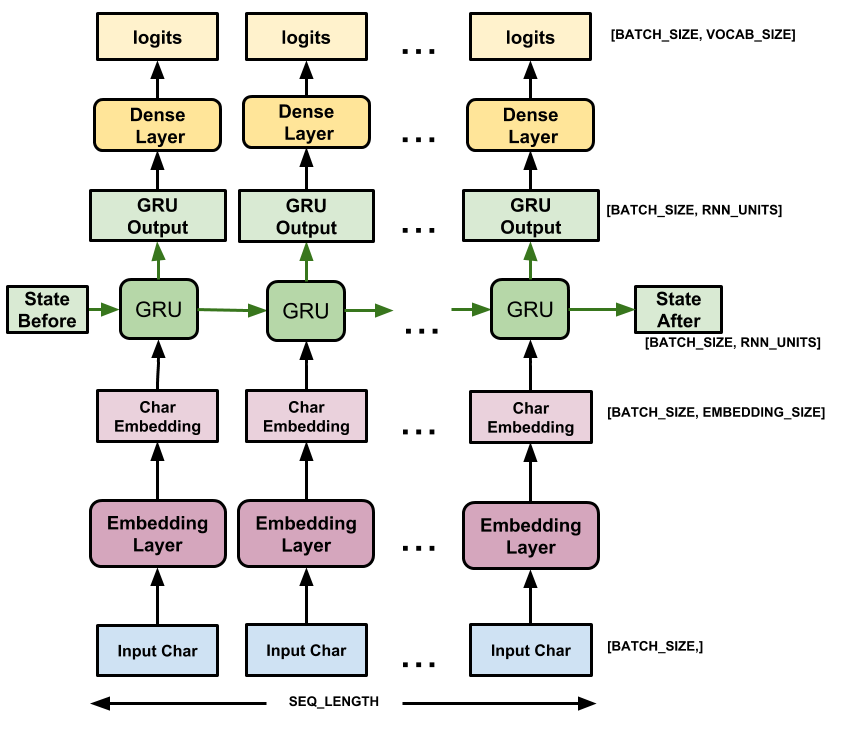
